# Cloud detection around montreux city

## Introducing the inputs

ALCD requires several types of data for its execution

 - raster data on which the classification iterations will be performed.
 - json files to parameterise the chain.

The following sections will focus on the presentation of this data.

### input rasters

ALCD currently only works with [Sentinel-2 L1C](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/) data. However, it will be shown in the [Custom stack](#custom-stack) section that it is possible to make ALCD use any type of data, as long as it is georeferenced.

For the rest of this tutorial, we will use data acquired by Sentinel-2 on 13/02/2024 centred on the town of Montreux in Switzerland.
This data will be stored in the directory `data_directory` and must have a particular tree structure, organised by scene. For example, the ``Montreux`` scene must contain Sentinel-2 data for different dates.

In [5]:
from pathlib import Path
from utils import show_tree

data_directory = Path("./s2")
show_tree(data_directory)

Button(description='Toggle Directory Tree', style=ButtonStyle())

Output(layout=Layout(display='none'))

Let's take a look at the data.

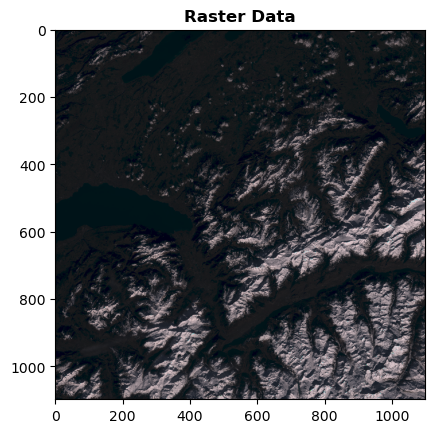

In [6]:
from utils import show_raster

s2_20241302_r = data_directory/"Montreux"/"S2A_MSIL1C_20240213T103141_N0510_R108_T32TLS_20240213T141145.SAFE"/"GRANULE"/"L1C_T32TLS_A045150_20240213T103555"/"IMG_DATA"/"T32TLS_20240213T103141_B04.jp2"
s2_20241302_g = data_directory/"Montreux"/"S2A_MSIL1C_20240213T103141_N0510_R108_T32TLS_20240213T141145.SAFE"/"GRANULE"/"L1C_T32TLS_A045150_20240213T103555"/"IMG_DATA"/"T32TLS_20240213T103141_B03.jp2"
s2_20241302_b = data_directory/"Montreux"/"S2A_MSIL1C_20240213T103141_N0510_R108_T32TLS_20240213T141145.SAFE"/"GRANULE"/"L1C_T32TLS_A045150_20240213T103555"/"IMG_DATA"/"T32TLS_20240213T103141_B02.jp2"

show_raster(s2_20241302_r, s2_20241302_g, s2_20241302_b)

The RGB visualisation shows us the presence of clouds in the upper section of the image, but also snow in the mountains. Confusing clouds with snow is a common occurrence in machine learning.

Now that the data is stored in the expected tree structure, we can review the ALCD launch parameters

### ALCD launching parameters

ALCD is launched using the python script ``all_run_alcd.py``.

The available options are:

- ``l``: the location. The spelling should be consistent with the names in the L1C directory
(e.g. Pretoria or Orleans)
- ``d``: the (cloudy) date that you want to classify (e.g. 20180319)
- ``c``: the clear date that will help the classification (e.g. 20180321)
- ``f``: if this is the first iteration or not. If set to True, it will compute and create all
the features, and create the empty class layers. Set it to True for the first iteration, and
thereafter to False.
- ``s``: the step you want to do, the choice is between 0 and 1. 0 will create all the needed
files if this is the first iteration, otherwise it will save the previous iteration. 1 will run the
ALCD algorithm, i.e train a model and classify the image. For each iteration, you should
set it to 0, modify the masks, and then set it to 1.
- ``kfold``: boolean. If set to True, ALCD will perform a k-fold cross-validation with the
available samples.
- ``dates``: boolean. If set to True, ALCD will display the available dates for the given
location.
- ``global_parameters``: path to json file which parametrize ALCD
- ``paths_parameters``: path to json file which contain useful paths for ALCD
- ``model_parameters``: path to json file which contain classifier parameters

The last 3 parameters are json files containing parameters relating to the various stages of ALCD (image reading, learning, etc.). The next section describes the parameters required to launch the processing chain.

### Contents of the configuration files

The first configuration file we are going to describe is the one to be filled in with the ``model_parameters`` parameter.

#### model_parameters

An example is available [model_parameters.json](model_parameters.json)

Ce fichier contient pour chaque classifier utilisable dans l'application otb [TrainVectorClassifier](https://www.orfeo-toolbox.org/CookBook-6.2/Applications/app_TrainVectorClassifier.html) les options à utiliser par ALCD. Par exemple le contenu du fichier peut être :

This file contains the options to be used by ALCD for each classifier that can be used in the otb [TrainVectorClassifier](https://www.orfeo-toolbox.org/CookBook-6.2/Applications/app_TrainVectorClassifier.html) application. For example, the contents of the file could be :

```json
{    
   	"libsvm" : {
		"k":"linear",
		"m" : "csvc",
		"c" : "1",
		"opt" : "false",
		"prob" : "false"
	},
   	"rf" : {
		"max":"25",
		"min" : "25",
		"ra":"0",
		"cat" : "10",
		"var" : "0",
		"nbtrees":"100",
		"acc" : "0.01"
	},
}
```

In this example if the ``rf`` algorithm is selected then 100 trees will be used etc. For an exhaustive list of parameters, see the otb [TrainVectorClassifier](https://www.orfeo-toolbox.org/CookBook-6.2/Applications/app_TrainVectorClassifier.html) documentation.

#### paths_parameters

An example is available [paths_configuration.json](paths_configuration.json)

This file contains the following information

```json
{
   "data_paths": {
      "data_alcd": "montreux_outputs"
   },
   "global_chains_paths": {
      "L1C": "s2"
   },
   "tile_location": {
      "Montreux": "32TLS"
   }
}
```

- ``data_alcd``: must point to an output directory.
- ``L1C``: must point to the Sentinel-2 data where the tree structure described in [input rasters](#input-rasters) is respected.
- ``tile_location`` allows you to select one of the scenes in the directory pointed to by ``L1C``. In our case ``Montreux``. The per-scene field is used to create the output directory. The output directory is constructed as follows: ‘tile_location.key’_‘tile_location.key.value’_date where date is the date selected in the command line.

#### global_parameters

An example is available [global_parameters.json](global_parameters.json). 

Contains the parameters for the various algorithms used.  For example, this is the place where the classifier is chosen (rf, libsvm, etc.). We'll focus here on the ``color_tables`` field.

```json
{
   "color_tables": {
      "otb": "otb_table.txt"
   }
}
```

which must point to a text file containing the RGB information for each of the classes. It is this colour table that will be used to create the final classifications. Here is en example with 3 classes :

```text
# Lines beginning with a # are ignored
# class R G B
0 195 255 42
# background
1 187 83 58
# low clouds
2 210 210 210
```

## ALCD's first launch on the scene

### Launching command

Now that the configuration files have been filled in, we can launch the first stage of ALCD, which will create 

    - the ALCD output directories
    - the stack of primitives
    - the empty database required for training purposes.

To launch this preliminary stage, we need to use the following launch options

- force True: to overwrite existing files
- s 0: to launch the first stage.
- f True: tells ALCD that this is not a new iteration. ‘f’ meaning ’first step ?
- l Montreux: selects the scene to be processed (location)
- d 20240213: the date to use in the available scene
- c 20240213: the clear date to be used for the available scene. If no date available, can be equal to d.
- kfold False: do not perform kfold learning.



In [7]:
%%bash
# considering PATH_ALCD is the path to the script 'all_run_alcd.py'
export PATH_ALCD="../../.."
python $PATH_ALCD/all_run_alcd.py -force True -s 0 -f True -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > tuto_log.txt

/home/ecadaux/miniconda3/envs/env_otb2/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Results analysis

When the command has finished, the results should be present in the output directory with the following tree structure

In [8]:
from pathlib import Path
from utils import show_tree

data_directory = Path("./montreux_outputs")
show_tree(data_directory)

Button(description='Toggle Directory Tree', style=ButtonStyle())

Output(layout=Layout(display='none'))

- ``In_data/Image`` Contains the feature stacks that can be used during training. The .txt versions show which band corresponds to which feature in the ``Intermediate`` directory.
  
- ``In_data/Masks`` Contains the empty databases representing the model's learning points. By default ALCD offers: background, clouds_shadows, high_clouds, land, low_clouds, snow, water and no_data.

- ``Intermediate`` Contains the feature used to build the stacks present in In_data/Image.

## Launching the next stages

Before launching the following actions must be taken by the user: 

1. modify the configuration file ``global_parameters.json``.
2. update the databases previously created by ALCD.
   
### Update global_parameters.json

the ``user_choices`` section needs updating, particularly the ``main_dir`` and ``raw_img`` fields, which represent respectively where the feature stack are stored and their names.

```json
{
   "user_choices": {
      "clear_date": "XXXX",
      "current_date": "XXXX",
      "location": "XXXX",
      "main_dir": "montreux_outputs/Montreux_32TLS_20240213",
      "raw_img": "Montreux_bands.tif",
      "tile": "XXXX"
   }
}
```

### Update learning databases

As seen above, ALCD has created empty learning databases, in ``In_data/Masks``, for each of the desired classes. It is up to the user to fill in these databases using visualisation tools such as [Qgis](https://qgis.org/download/) or others. 

Once the ``global_parameters.json`` file and the databases have been updated, we can launch the rest of the processing.

### Launching command 

The command to run is almost identical to the previous one, except that the ``s`` option changes from 0 to 1.

In [9]:
%%bash
export PATH_ALCD="../../.."
python $PATH_ALCD/all_run_alcd.py -force True -s 1 -f True -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > tuto_log.txt

/home/ecadaux/miniconda3/envs/env_otb2/lib/python3.11/site-packages/osgeo/ogr.py:560: FutureWarning: Neither ogr.UseExceptions() nor ogr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
[pos171665lx:92255:0:92255] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x10)
==== backtrace (tid:  92255) ====
 0  /home/ecadaux/miniconda3/envs/env_otb2/lib/otb/python/../.././././libucs.so.0(ucs_handle_error+0x2fd) [0x7ba2cc23ccfd]
 1  /home/ecadaux/miniconda3/envs/env_otb2/lib/otb/python/../.././././libucs.so.0(+0x2def4) [0x7ba2cc23cef4]
 2  /home/ecadaux/miniconda3/envs/env_otb2/lib/otb/python/../.././././libucs.so.0(+0x2e0ba) [0x7ba2cc23d0ba]
 3  /lib/x86_64-linux-gnu/libc.so.6(+0x45320) [0x7ba2f1e45320]
 4  /home/ecadaux/miniconda3/envs/env_otb2/lib/otb/applications/otbapp_PolygonClassStatistics.so(_ZN3otb7Wrapper22PolygonClassStatistics18DoUpdateParametersEv+0x228) [0x7ba2c5c98fc8]
 5  /home/eca

CalledProcessError: Command 'b'export PATH_ALCD="../../.."\npython $PATH_ALCD/all_run_alcd.py -force True -s 1 -f True -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > tuto_log.txt\n'' returned non-zero exit status 139.

### Results analysis

When the command has finished, the results should be present in the output directory with the following tree structure

In [6]:
from pathlib import Path
from utils import show_tree

data_directory = Path("./montreux_outputs")
show_tree(data_directory)

Button(description='Toggle Directory Tree', style=ButtonStyle())

Output(layout=Layout(display='none'))

The final results are all stored in the /Out directory

- ``colorized_classif.png``: the final classification with a different colour for each class
- ``confidence.tif`` confidence map
- ``confidence_enhanced.tif``: confidence map averaged over a window of radius 11
- ``labeled_img.tif``: final classification
- ``labeled_img_regular.tif`` final classification regularised in a window of radius 2.
- ``contours_labels.tif``: contour map
- ``contours_superposition.png``: quicklook of the contours map superimposed on the image to be classified.
- ``Quicklook.png``: quicklook acquisition to be classified.

Here are the results after the first classification by ALCD.

<div style="display: flex; justify-content: space-around;">
    <figure style="text-align: center;">
        <img src="montreux_outputs/Montreux_32TLS_20240213/Out/quicklook.png" alt="Image 2" style="width: 400px;">
        <figcaption>Sentinel-2 acquisition</figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="montreux_outputs/Montreux_32TLS_20240213/Out/colorized_classif.png" alt="Image 1" style="width: 400px;">
        <figcaption>Sentinel-2 classified</figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="../images/table.png" alt="Image 2" style="width: 400px;">
        <figcaption>legend</figcaption>
    </figure>
</div>

### Start next iteration

If the results are not satisfactory, it is possible to re-train by updating the training database. Before doing this, you need to save what was done previously with the command

In [7]:
%%bash
# considering PATH_ALCD is the path to the script 'all_run_alcd.py'
export PATH_ALCD="../../.."
python $PATH_ALCD/all_run_alcd.py -force False -s 0 -f False -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > log_tuto.txt

The use of ``-s 0 -f False`` triggers a copy of the previous run in the ``Previous_iterations`` directory, which was initially empty. This backup can be used to track the evolution of classifications over the course of iterations.

After this command has been run, it is possible to modify the initial training database. In our case, the results for water were disappointing. We will add water samples.

Then run ALCD again with the command

In [8]:
%%bash
# considering PATH_ALCD is the path to the script 'all_run_alcd.py'
export PATH_ALCD="../../.."
python $PATH_ALCD/all_run_alcd.py -force False -s 1 -f False -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > log_tuto.txt

RandomSampler (0x562db2f18850): Needed elements (8000) will be clamped to total elements (423)


RandomSampler (0x562db22d4990): Needed elements (8000) will be clamped to total elements (208)


RandomSampler (0x562db22d2d10): Needed elements (8000) will be clamped to total elements (310)


RandomSampler (0x562db2f00c40): Needed elements (8000) will be clamped to total elements (495)


RandomSampler (0x562db2f00960): Needed elements (8000) will be clamped to total elements (456)




The results generated during this iteration overwrite the previous ones. With the addition of samples, we can see an evolution in the classification

<div style="display: flex; justify-content: space-around;">
    <figure style="text-align: center;">
        <img src="montreux_outputs/Montreux_32TLS_20240213/Out/quicklook.png" alt="Image 2" style="width: 400px;">
        <figcaption>Sentinel-2 acquisition</figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="montreux_outputs/Montreux_32TLS_20240213/Out/colorized_classif.png" alt="Image 1" style="width: 400px;">
        <figcaption>Sentinel-2 classified</figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="../images/table.png" alt="Image 2" style="width: 400px;">
        <figcaption>legend</figcaption>
    </figure>
</div>

## Advance usages

### Custom stack

As we saw in [at the beginning of the tutorial](#launching-the-next-stages), the user must specify which features should be used to learn a model. For example, it is possible to change ALCD's initial function from cloud detection to water detection using Sentinel-1 images.

All the user has to do is place his own stack of features in the ``In_data/Image`` directory and enter its name in the ``global_parameters.json`` Json file in the ``user_choices.raw_img`` field.

### Class definition

The classes to be used during ALCD execution are defined in the Json file ``global_parameters.json``, in the ``masks`` section.

An example of classes is shown below.

```json
"masks": {
      "background": {
         "class": "1",
         "shp": "background.shp"
      },
      "clouds_shadows": {
         "class": "4",
         "shp": "clouds_shadows.shp"
      },
      "high_clouds": {
         "class": "3",
         "shp": "high_clouds.shp"
      }
   }
```

There are 3 classes with their representation in the form of a character string, an integer and the file which will contain the database for this class. 

If we want to add a ``forest`` class, then the file will contain

```json
"masks": {
      "background": {
         "class": "1",
         "shp": "background.shp"
      },
      "clouds_shadows": {
         "class": "4",
         "shp": "clouds_shadows.shp"
      },
      "high_clouds": {
         "class": "3",
         "shp": "high_clouds.shp"
      },
      "forest": {
         "class": "4",
         "shp": "forest.shp"
      },
   }
```

### Other classification  algorithms

The user can choose the classification algorithm by modifying the *"method"* field in the *global_parameters.json* *"classification"* section.

Classification can be performed using either Orfeo ToolBox (OTB) or scikit-learn, the following algorithms are available :


- [OTB Algorithms](https://www.orfeo-toolbox.org/CookBook/Applications/app_TrainImagesClassifier.html)

    - Random Forest, *"method": "rf_otb"*
    - SVM, *"method": "svm_otb"*
    - Boosting, *"method": "boost_otb"*
    - Decision Tree, *"method": "dt_otb"*
    - Gradient Boosted Tree, *"method": "gbt_otb"*
    - K-Nearest Neighbors, *"method": "knn_otb"*
      

- [scikit-learn Algorithms](https://scikit-learn.org/1.5/api/sklearn.ensemble.html)

    - Random Forest, *"method": "rf_scikit"*
    - SVM, *"method": "svm_scikit"*
    - AdaBoost, *"method": "ada_scikit"*
    - Extra trees, *"method": "xtree_scikit"*
    - Gradient Boosting, *"method": "grad_scikit"*
    - Histogram-based Gradient Boosting, *"method": "hist_grad_scikit"*

The parameters for the choosen algorithm can be changed in the *model_parameters.json* file as explained in previous sections.


### User primitives

Users can integrate custom processes to modify the input data before classification by adding *"user_function"* and *"user_module"* fields in the "user_choices" section of the *global_parameters.json* file:

```json
"user_choices": {
    "user_module": , //Path to the Python file containing the user's process
    "user_function": , //Name of the function to apply
    //Other fields to specify
}
```

The custom function accepts a xarray.DataArray as input and return the modified xarray.DataArray.

This allows users to add or remove bands, compute indices, or perform any other transformations. For example, a function can remove bands and compute indices such as NDSI and add them to the input data. Below is a example from *tests/users_function.py*:


```python
def my_process(in_tab : xr.DataArray) -> xr.DataArray :
    """
    Computes the NDSI of the input image
    """
    new_band =  (in_tab.loc['B03'] - in_tab.loc['B11']) / (in_tab.loc['B03'] + in_tab.loc['B11'])

    # band_list = list(in_tab.coords['band'].values)
    # band_list.remove("B01")
    band_list = ['B02', 'B03', 'B04', 'B08', 'NDVI', 'NDWI']

    out_tab = in_tab.sel(band=band_list)
    out_tab = xr.concat(
        [
            out_tab,
            new_band.expand_dims(band=["NDSI"]),
        ], dim='band',
    )
    return out_tab
```


If no modifications to the input data are needed, remove the *"user_function"* and *"user_module"* fields from *global_parameters.json*.

If updates have been added to the user function, re-run the first stage with the following command after making the changes :

```bash
python $PATH_ALCD/all_run_alcd.py -force True -s 0 -f True -l Montreux -d 20240213 -c 20240213 -dates False -kfold False -global_parameters global_parameters.json -paths_parameters paths_configuration.json -model_parameters model_parameters.json > tuto_log.txt
```

This ensures that the new function has been correctly applied to the input data.